In [16]:
#import necessary libraries and Modules
import ImageManipFuncs as IMF
import PlottingFuncs as PF
import ImageAnalysis as IA
import myGUI 
import photoutils
import importlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import ipywidgets as widgets
from IPython.display import display
import math
from PIL import Image, ImageDraw, ImageTk, ImageOps
import tkinter as tk
from tkinter import ttk
from astropy.io import fits
from skimage.morphology import skeletonize
from skimage import io
import csv
import Metric

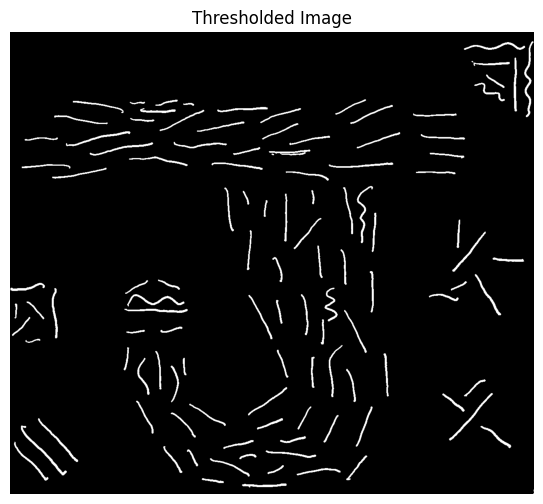

In [17]:
importlib.reload(IMF)
importlib.reload(PF)
importlib.reload(IA)
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths and image loading
original_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\MetricTest.png'
image_data = cv2.imread(original_image_path, cv2.IMREAD_COLOR)
image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
image_data = image_data.astype(np.uint8)

# Apply adaptive threshold
total_thresh = cv2.adaptiveThreshold(image_data, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, -10)

# Save the thresholded image
cv2.imwrite(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThresholdedTest.png', total_thresh)

# Display the results
plt.figure(figsize=(8, 6))
plt.title('Thresholded Image')
plt.imshow(total_thresh, cmap='gray')
plt.axis('off')
plt.show()


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects
import networkx as nx
from skimage import measure

def skeleton_analysis(skeleton, image, prune=False, prune_criteria='length', relintens_thresh=0.5,
                      branch_thresh=None, verbose=False, save_png=False, save_name=None):
    """
    Analyze a skeletonized filament and return the longest path after optional pruning.
    
    Parameters:
    - skeleton: A 2D numpy array representing the skeletonized filament.
    - image: The original image (2D numpy array) from which the skeleton was extracted.
    - prune: Boolean flag to determine whether pruning is applied.
    - prune_criteria: Criteria for pruning ('length' or 'intensity').
    - relintens_thresh: Relative intensity threshold for pruning if pruning by intensity.
    - branch_thresh: Length threshold for pruning if pruning by length.
    - verbose: If True, display the skeleton images.
    - save_png: If True, save the images.
    - save_name: Name prefix for saved images.

    Returns:
    - longest_path_skeleton: A 2D numpy array of the longest path in the pruned skeleton.
    """

    # Ensure skeleton is binary
    skeleton = (skeleton > 0).astype(int)

    if verbose:
        plt.imshow(skeleton, cmap='gray')
        plt.title("Original Skeleton")
        plt.show()

    # Pruning based on the criteria
    if prune:
        if prune_criteria == 'length':
            if branch_thresh is not None:
                skeleton = remove_small_objects(skeleton.astype(bool), min_size=branch_thresh).astype(int)
        elif prune_criteria == 'intensity':
            labeled_skeleton, num_features = measure.label(skeleton, return_num=True)
            for region in measure.regionprops(labeled_skeleton, intensity_image=image):
                if region.mean_intensity < relintens_thresh:
                    skeleton[labeled_skeleton == region.label] = 0

        if verbose:
            plt.imshow(skeleton, cmap='gray')
            plt.title("Pruned Skeleton")
            plt.show()

    # Convert skeleton to graph
    graph = nx.Graph()
    skeleton_points = np.argwhere(skeleton)

    for point in skeleton_points:
        graph.add_node(tuple(point))

    for point in skeleton_points:
        for neighbor in [[0, 1], [1, 0], [0, -1], [-1, 0], [1, 1], [1, -1], [-1, 1], [-1, -1]]:
            neighbor_point = point + neighbor
            if tuple(neighbor_point) in graph:
                graph.add_edge(tuple(point), tuple(neighbor_point))

    # Find the longest path in the pruned skeleton
    longest_path_length = 0
    longest_path_coords = []

    if len(graph.nodes) > 0:
        for source in graph.nodes():
            for target in graph.nodes():
                if source != target:
                    try:
                        length = nx.dijkstra_path_length(graph, source, target)
                        if length > longest_path_length:
                            longest_path_length = length
                            longest_path_coords = nx.dijkstra_path(graph, source, target)
                    except nx.NetworkXNoPath:
                        continue

    # Create the longest path skeleton
    longest_path_skeleton = np.zeros_like(skeleton)
    for coord in longest_path_coords:
        longest_path_skeleton[coord] = 1

    if verbose:
        plt.imshow(longest_path_skeleton, cmap='gray')
        plt.title("Longest Path in Skeleton")
        plt.show()

    if save_png and save_name:
        plt.imsave(f"{save_name}_original_skeleton.png", skeleton, cmap='gray')
        if prune:
            plt.imsave(f"{save_name}_pruned_skeleton.png", skeleton, cmap='gray')
        plt.imsave(f"{save_name}_longest_path.png", longest_path_skeleton, cmap='gray')

    return longest_path_skeleton


DETECTING
deblending


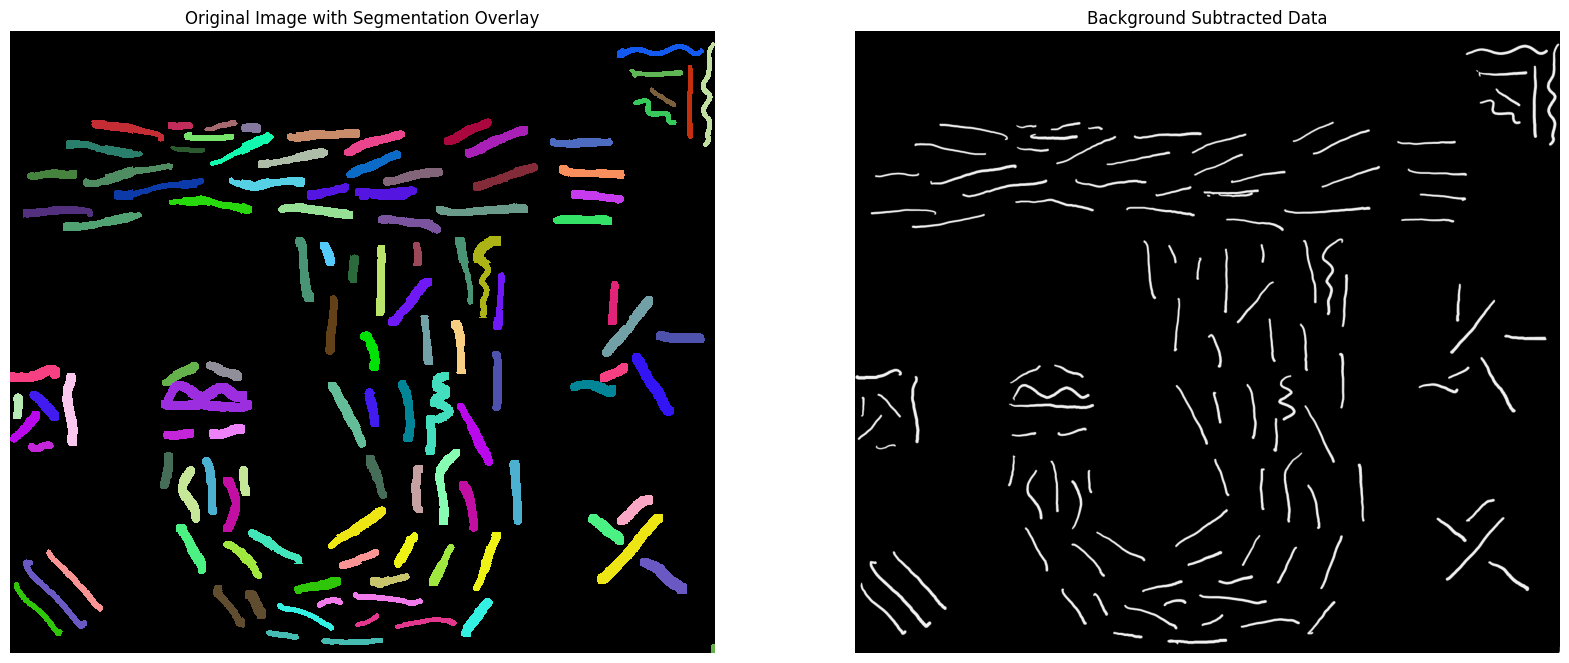

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.segmentation import make_2dgaussian_kernel, detect_sources, deblend_sources
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from matplotlib.colors import ListedColormap

data = image_data
data = data.astype(np.float64)

# Background subtraction
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
data -= bkg.background

# Thresholding and convolution
threshold = .5*bkg.background_rms
kernel = make_2dgaussian_kernel(3.0, size=11)
convolved_data = convolve(data, kernel)

# Source detection and deblending
print('DETECTING')
segment_map = detect_sources(convolved_data, threshold, npixels=100)
print("deblending")
segment_map = deblend_sources(convolved_data, segment_map, npixels=200, nlevels=100, contrast=0.001, progress_bar=False)

# Colormap and normalization
num_segments = segment_map.data.max()
colors = np.random.rand(num_segments + 1, 3)
colors[0] = [0, 0, 0]  # Background as black
cmap = ListedColormap(colors)

norm = ImageNormalize(stretch=SqrtStretch())
segmentation_image_normalized = norm(segment_map.data)
segmentation_image_flipped = np.flipud(segmentation_image_normalized)
data_flipped = np.flipud(data)

# Plot and save
fig, axes = plt.subplots(1, 2, figsize=(20, 12.5))

axes[0].imshow(segmentation_image_flipped, origin='lower', cmap=cmap, alpha=1, interpolation='nearest')
axes[0].set_title('Original Image with Segmentation Overlay')
axes[0].axis('off')

axes[1].imshow(data_flipped, cmap='gray', origin='lower')
axes[1].set_title('Background Subtracted Data')
axes[1].axis('off')

# Save the subplot image
subplot_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\overlaid_subplot_image_test.png'
plt.imsave(subplot_image_path, segmentation_image_flipped, cmap=cmap)

# Save the binary segmented image
binary_segment_image = (segment_map.data > 0).astype(np.uint8) * 255
image_path_segments = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\segments_test.png'
plt.imsave(image_path_segments, binary_segment_image, cmap='gray')

# Normalize and save the zoomed image
#data_flipped = data_flipped.astype(np.uint8) * 255
data_flipped = np.nan_to_num(data_flipped, nan=0)
image_path_zoomed = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\zoomed_image_Test.png'
plt.imsave(image_path_zoomed, data_flipped, cmap='gray')

# Show the plot
plt.show()


(1140, 1292)
(1140, 1292)
on filament 1
on filament 2
on filament 3
on filament 4
on filament 5
on filament 6
on filament 7
on filament 8
on filament 9
on filament 10
on filament 11
on filament 12
on filament 13
on filament 14
on filament 15
on filament 16
on filament 17
on filament 18
on filament 19
on filament 20
on filament 21
on filament 22
on filament 23
on filament 24
on filament 25
on filament 26
on filament 27
on filament 28
on filament 29
on filament 30
on filament 31
on filament 32
on filament 33
on filament 34
on filament 35
on filament 36
on filament 37
on filament 38
on filament 39
on filament 40
on filament 41
on filament 42
on filament 43
on filament 44
on filament 45
on filament 46
on filament 47
on filament 48
on filament 49
on filament 50
on filament 51
on filament 52
on filament 53
on filament 54
on filament 55
on filament 56
on filament 57
on filament 58
on filament 59
on filament 60
on filament 61
on filament 62
on filament 63
on filament 64
on filament 65
on filam

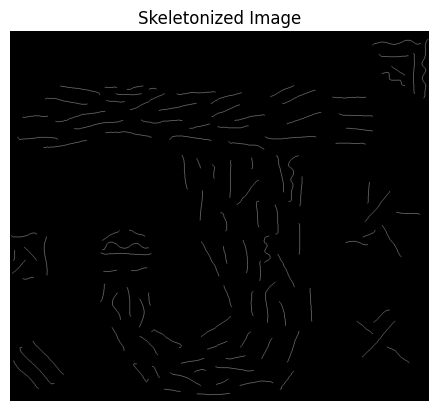

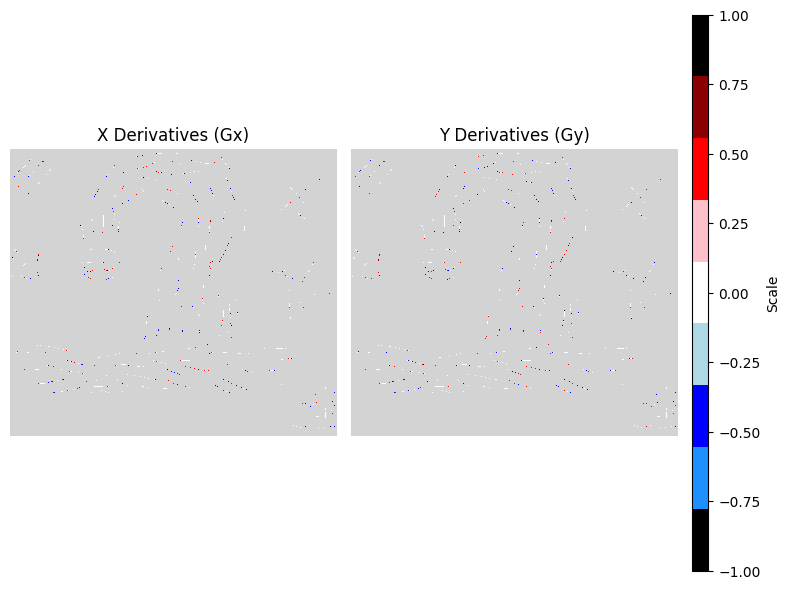

In [20]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
import importlib

# Assuming segment_map is already defined from previous segmentation process

# Read the binary segmented image
image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\segments_test.png'
original_img = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\MetricTest.png'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
og_img = cv2.imread(original_img, cv2.IMREAD_GRAYSCALE)
og_img = og_img.astype(np.uint8)
print(np.shape(img))
print(np.shape(og_img))
# Number of segments
num_segments = segment_map.data.max()

# Initialize Gx and Gy matrices to store results for the entire image
Gx_total = np.zeros_like(img, dtype=np.float64)
Gy_total = np.zeros_like(img, dtype=np.float64)
skel = np.zeros_like(img, dtype=np.float64)

# Loop through each segment to create and display individual masks
for i in range(1, num_segments + 1):
    print(f"on filament {i}")
    # Create a mask where only the current segment is white
    mask = np.zeros_like(segment_map.data, dtype=np.uint8)
    mask[segment_map.data == i] = 255
    skeleton = skeletonize(mask)
    
    # Convert skeleton to uint8
    skeleton = skeleton.astype(np.uint8) * 255
    longest_path = skeleton_analysis(skeleton, og_img, prune=True, prune_criteria='intensity', relintens_thresh=0.5,
                      branch_thresh=None, verbose=False, save_png=False, save_name=None)
    # # Display the skeletonized mask
    # plt.imshow(skeleton, cmap='gray')
    # plt.title(f'Skeletonized Mask for Segment {i}')
    # plt.axis('off')
    # plt.show()

    # Apply Sobel filter to the masked component
    longest_path = longest_path.astype(np.float32)
    sobelx = cv2.Sobel(longest_path, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(longest_path, cv2.CV_64F, 0, 1, ksize=3)
    
    Gx_total += sobelx
    Gy_total += sobely
    skel+=longest_path

image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\seg_skel_test.png'
# Load the image in grayscale
mask_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imsave(image_path, skel, cmap='gray')

# Display the skeletonized image using matplotlib
plt.imshow(skel, cmap='gray')
plt.title('Skeletonized Image')
plt.axis('off')
plt.show()



PF.plot_sobel_derivatives(mask_img, Gx_total, Gy_total)


c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:99: RuntimeWarning: divide by zero encountered in divide
  angle_map = -1 * np.degrees(np.arctan(Gy / Gx))
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:99: RuntimeWarning: invalid value encountered in divide
  angle_map = -1 * np.degrees(np.arctan(Gy / Gx))
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:84: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arctan(sin_sum/cos_sum))


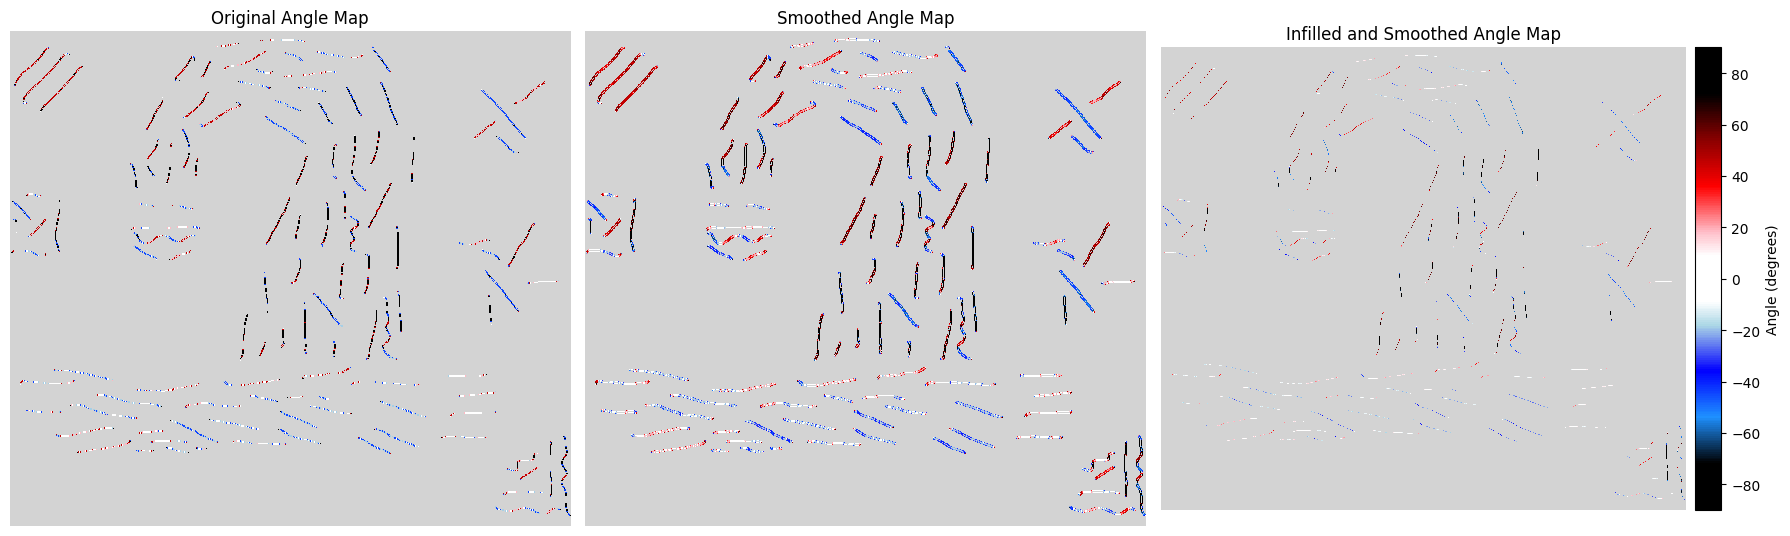

Smoothed angle map saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles_test.png


In [21]:
importlib.reload(PF)
smoothed_angles = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles_test.png'


smoother_angle_map, smoothed_angled_map = PF.plot_arctan_with_smoothing(Gy_total, Gx_total, mask_img, 3, smoothed_angles)

nan
nan


c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\Metric.py:60: RuntimeWarning: invalid value encountered in scalar divide
  return 2*(total_sum/sum_weights)-1


Number of hexagons: 72
47.008152122012284 11.10549752585772


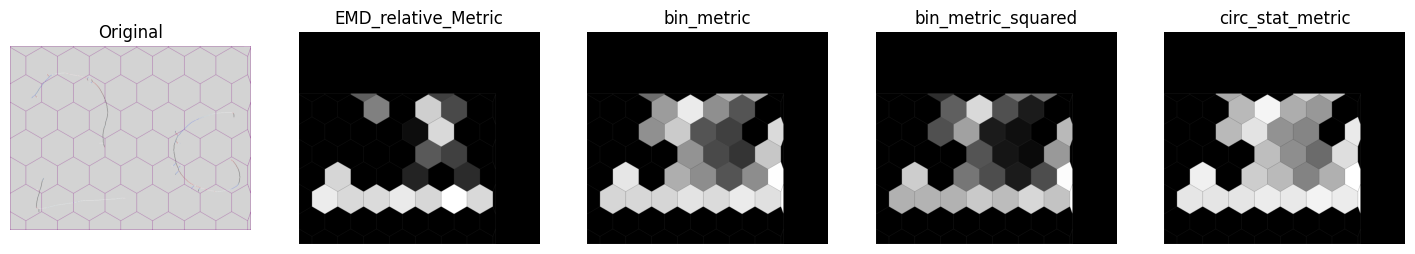

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import csv
import importlib

# Reload your GUI module if necessary
importlib.reload(myGUI)
importlib.reload(Metric)
import pandas as pd 
import RHT 
import math 
import CircularEMDTest as CT
importlib.reload(CT)
importlib.reload(IA)

# Paths and image loading
angle_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png'
angle_img = cv2.imread(angle_image_path, cv2.COLOR_BGR2RGB)

hex_sizes = [80]

for hexagon_size in hex_sizes: 
    # Hexagon settings
    hexagons, hexagon_image_og = myGUI.display_image_with_hexagons(angle_image_path, hexagon_size)
    hexagon_centers = [x[0] for x in hexagons]
    hexagon_corners = [x[1] for x in hexagons]
    hex_dict = {}

    # Path to the original image
    # Load the original image in grayscale mode
    original_img = data


    for i in range(len(hexagon_corners)):
        
        EMD_sum = 0
        alignment_sum = 0
        hist_metric_sum = 0

        for j in range(3):
            if j == 0:
                shift_x = 0
                shift_y = 0
            elif j ==1: 
                shift_x = -(hexagon_corners[i][5][0] - hexagon_centers[i][0])
                shift_y = -(hexagon_corners[i][5][1] - hexagon_centers[i][1])
            elif j == 2:
                shift_x = -(hexagon_corners[i][2][0] - hexagon_centers[i][0])
                shift_y = -(hexagon_corners[i][2][1] - hexagon_centers[i][1])
            # Apply shift to all corners for the current `j`
            shifted_corners = [(x + shift_x, y + shift_y) for (x, y) in hexagon_corners[i]]

            mask = myGUI.get_hexagon_mask(image_data.shape, shifted_corners)

            data_in_hexagon = smoother_angle_map[mask == 255]
            data_in_hexagon = [x for x in data_in_hexagon if not np.isnan(x)]
            # Assuming skel, mask, smoother_angle_map, image_data, and IA.identify_connected_components are defined

            # Convert skel to uint8 for compatibility with cv2 functions
            skel = skel.astype(np.uint8)

            # Apply the binary mask to skel. Where mask == 255, skel values are preserved; otherwise, set to 0.
            masked_skel = np.where(mask == 255, skel, 0).astype(np.uint8)
            # Create a figure and two subplots (side by side)

            labels, stats, num_labels = IA.identify_connected_components(masked_skel.astype(np.uint8))
            if (num_labels-1) != 0:
                # fig, ax = plt.subplots(1, 3, figsize=(12, 6))  # Adjust figsize as needed

                # # Display masked_skel in the first subplot
                # ax[0].imshow(masked_skel, cmap='gray')
                # ax[0].set_title('Masked Skeleton')
                # ax[0].axis('off')  # Hide the axis
                # # Display mask in the second subplot
                # ax[2].imshow(mask, cmap='gray')
                # ax[2].set_title('Mask')
                # ax[2].axis('off')  # Hide the axis
                # # Display mask in the second subplot
                # ax[1].imshow(skel, cmap='gray')
                # ax[1].set_title('Mask')
                # ax[1].axis('off')  # Hide the axis

                # # Show the plot
                # plt.tight_layout()  # Adjust layout to prevent overlap
                # plt.show()
                # # Identify connected components in the masked skeleton image
                # print(num_labels-1)
            # Dictionary to hold segment data
                segment_dict = {}

                for segment in range(1, num_labels):
                    # Extract the bounding box coordinates for the segment
                    x, y, w, h, _ = stats[segment]

                    # Create a mask for the segment
                    seg_mask = np.zeros_like(skel, dtype=np.uint8)
                    seg_mask[y:y+h, x:x+w] = 255

                    # Apply the segment mask to the skeleton image
                    # Ensure both masks are of type uint8
                    segment_mask = cv2.bitwise_and(skel, seg_mask)

                    # Collect pixel values for the segment
                    # Ensure segment_mask is boolean for indexing
                    segment_mask_bool = segment_mask > 0
                    segment_data = smoother_angle_map[segment_mask_bool]
                    segment_data = [x for x in segment_data if not np.isnan(x)]

                    # Skip the segment if segment_data is empty
                    if not segment_data:
                        continue

                    # Ensure segment_mask is used properly for indexing
                    intensity = np.sum(image_data[segment_mask_bool])

                    # Store segment data in the dictionary
                    segment_dict[segment] = (segment_data, intensity)

                if len(segment_dict.keys()) >= 2:
                    EMD_sum += CT.compute_my_metric(segment_dict)
                else:
                    EMD_sum += np.nan
                alignment_sum  += Metric.alignment_metric(data_in_hexagon)
                hist_metric_sum += Metric.compute_my_metric(data_in_hexagon)

            else:

                EMD_sum += np.nan
                alignment_sum   += np.nan
                hist_metric_sum  += np.nan

        if round(hist_metric_sum/3,2) == .21 or round(hist_metric_sum/3,2)==.22:
            plt.imshow(masked_skel, cmap='gray')
            print(num_labels-1)
            plt.show()
        hex_dict[hexagon_centers[i]] = (EMD_sum/3, len(data_in_hexagon), num_labels-1, alignment_sum/3,hist_metric_sum/3, shifted_corners)

    print(f'Number of hexagons: {len(hexagon_centers)}')

    # Create a new image to draw the hexagons filled with the alignment metric colors
    hexagon_image1 = Image.new("RGB", (img.shape[1], img.shape[0]))
    hexagon_image2 = Image.new("RGB", (img.shape[1], img.shape[0]))
    hexagon_image3 = Image.new("RGB", (img.shape[1], img.shape[0]))
    hexagon_image4 = Image.new("RGB", (img.shape[1], img.shape[0]))

    draw1 = ImageDraw.Draw(hexagon_image1)
    draw2 = ImageDraw.Draw(hexagon_image2)
    draw3 = ImageDraw.Draw(hexagon_image3)
    draw4 = ImageDraw.Draw(hexagon_image4)

    count = 0

    # Save hex_dict to CSV
    csv_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\thresholded_image.csv'
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Hexagon Center', 'Number of Pixels', 'num_segments','EMD relative Metric', 'my hist metric', 'my hist metric sq', 'circ stat metric'])

        # Extract the first elements from each tuple
        EMD_metrics = [info[0] for info in hex_dict.values() if not np.isnan(info[0])]
        hist_metrics = [info[4] for info in hex_dict.values() if not np.isnan(info[4])]

        # Calculate the max and min values of the first elements
        EMD_max_metric = max(EMD_metrics)
        EMD_min_metric = min(EMD_metrics)
        hist_max_metric = max(hist_metrics)
        hist_min_metric = min(hist_metrics)
        print(EMD_max_metric, EMD_min_metric)
        for center, info in hex_dict.items():
            EMD_metric = info[0]
            circ_stat_metric = info[3]
            hist_metric = info[4]
            number_of_pixels = info[1]
            segments = info[2]

            EMD_relative_metric = (EMD_metric - EMD_min_metric) / (EMD_max_metric - EMD_min_metric)
            hist_relative_metric = (hist_metric - hist_min_metric) / (hist_max_metric - hist_min_metric)

            # Check if segments is an empty list or contains NaN
            if not segments or isinstance(segments, float) and np.isnan(segments):
                num_seg = 0
            else:
                num_seg = segments

            writer.writerow([center, number_of_pixels, 1 - EMD_relative_metric, hist_metric, hist_metric**2, circ_stat_metric, num_seg])
            if not np.isnan(hist_metric):
                grayscale_value2 = int(255*hist_metric)
                grayscale_value3 = int(255*(hist_metric**2))  # Map to grayscale (0 to 255)
                grayscale_value4 = int(255*circ_stat_metric)
                corners = hexagon_corners[count]
                draw2.polygon(corners, fill=(grayscale_value2, grayscale_value2, grayscale_value2), outline="purple")
                draw3.polygon(corners, fill=(grayscale_value3, grayscale_value3, grayscale_value3), outline="purple")
                draw4.polygon(corners, fill=(grayscale_value4, grayscale_value4, grayscale_value4), outline="purple")
            else:
                corners = hexagon_corners[count]
                draw2.polygon(corners, fill=(0, 0, 0), outline="purple")
                draw3.polygon(corners, fill=(0, 0, 0), outline="purple")
                draw4.polygon(corners, fill=(0, 0, 0), outline="purple")
            if not np.isnan(EMD_relative_metric):
                grayscale_value1 = int(255 - EMD_relative_metric * 255)  # Map to grayscale (0 to 255)
                draw1.polygon(corners, fill=(grayscale_value1, grayscale_value1, grayscale_value1), outline="purple")
            else:
                corners = hexagon_corners[count]
                draw1.polygon(corners, fill=(0, 0, 0), outline="purple")
            count += 1

    # Convert PIL images to numpy arrays
    hexagon_image1_array = np.array(hexagon_image1.convert('L'))
    hexagon_image2_array = np.array(hexagon_image2.convert('L'))
    hexagon_image3_array = np.array(hexagon_image3.convert('L'))
    hexagon_image4_array = np.array(hexagon_image4.convert('L'))

    # Display the original and processed images with grayscale colormap
    fig, ax = plt.subplots(1, 5, figsize=(18, 18))  # Adjust the figsize as needed

    ax[0].imshow(np.flipud(hexagon_image_og))
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].imshow(np.flipud(hexagon_image1_array), cmap='gray')
    ax[1].set_title('EMD_relative_Metric')
    ax[1].axis('off')

    ax[2].imshow(np.flipud(hexagon_image2_array), cmap='gray')
    ax[2].set_title('bin_metric')
    ax[2].axis('off')

    ax[3].imshow(np.flipud(hexagon_image3_array), cmap='gray')
    ax[3].set_title('bin_metric_squared')
    ax[3].axis('off')

    ax[4].imshow(np.flipud(hexagon_image4_array), cmap='gray')
    ax[4].set_title('circ_stat_metric')
    ax[4].axis('off')

    # Define your hexagon images as numpy arrays
    hexagon_images = {
        'EMD_relative_Metric': hexagon_image1_array,
        'bin_metric': hexagon_image2_array,
        'bin_metric_squared': hexagon_image3_array,
        'circ_stat_metric': hexagon_image4_array
    }

    plt.show()


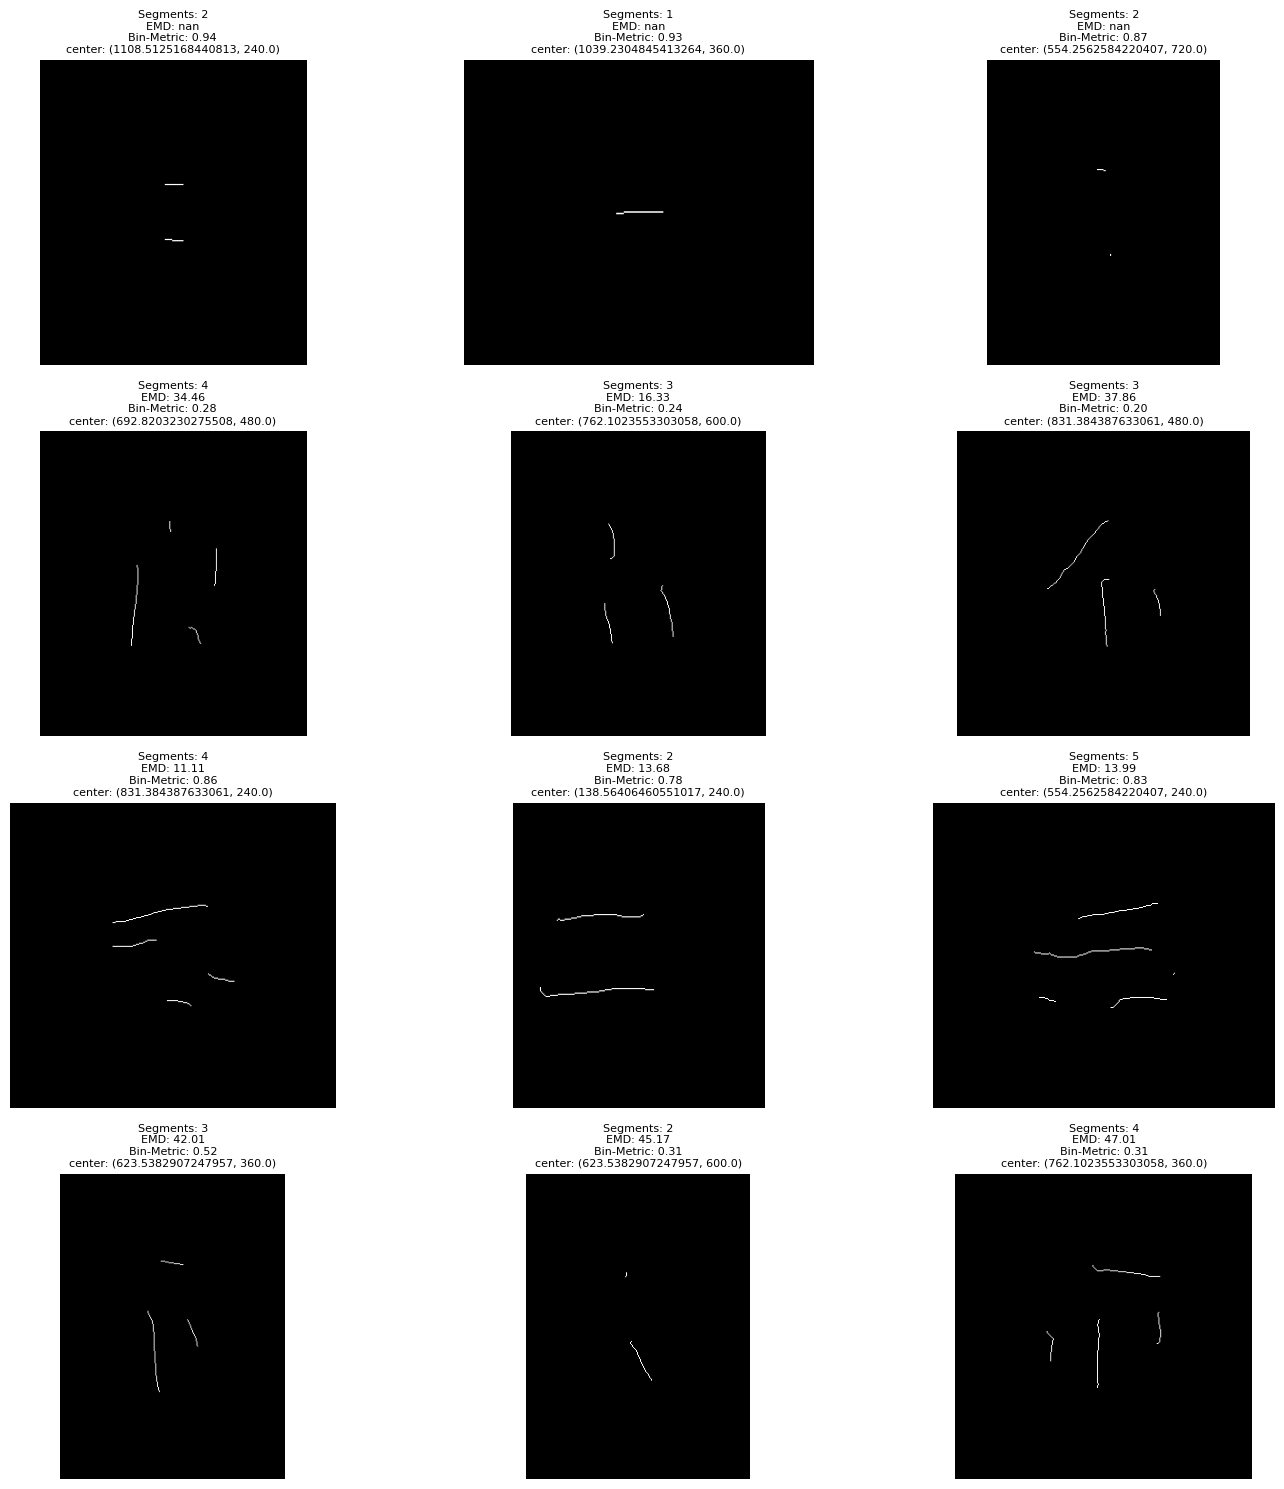

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Function to create a mask for a specific hexagon centered at `center`
def create_hexagon_mask(image_shape, center, corners):
    mask = myGUI.get_hexagon_mask(image_shape, corners)

    return mask

# Function to extract and zoom in on a specific hexagon region from the skel image
def extract_and_zoom_hexagon_region(skel_img, center, corners, zoom_factor=2):
    mask = create_hexagon_mask(skel_img.shape, center, corners)
    # Apply the binary mask to skel. Where mask == 255, skel values are preserved; otherwise, set to 0.
    masked_skel = np.where(mask == 255, skel, 0).astype(np.uint8)
    
    # Find bounding box of the hexagon
    y_indices, x_indices = np.where(masked_skel)
    if len(x_indices) == 0 or len(y_indices) == 0:
        return np.zeros((256, 256), dtype=np.uint8)  # Return a blank image if no region found
    
    min_x, max_x = min(x_indices), max(x_indices)
    min_y, max_y = min(y_indices), max(y_indices)
    
    # Extract region and zoom
    img_height, img_width = masked_skel.shape[:2]

    # Calculate initial crop boundaries
    crop_min_y = min_y - 100
    crop_max_y = max_y + 100
    crop_min_x = min_x - 100
    crop_max_x = max_x + 100

    # Ensure boundaries are within the image dimensions
    if crop_min_y < 0:
        crop_min_y = 0
    if crop_max_y > img_height:
        crop_max_y = img_height
    if crop_min_x < 0:
        crop_min_x = 0
    if crop_max_x > img_width:
        crop_max_x = img_width

    # Crop the image with adjusted boundaries
    region_cropped = masked_skel[crop_min_y:crop_max_y, crop_min_x:crop_max_x]
    return region_cropped

# Helper function to filter out items with NaN values in specific metric indices
def filter_nan_items(hex_dict, metric_index):
    filtered_dict = {k: v for k, v in hex_dict.items() if not np.isnan(v[metric_index])}
    return filtered_dict

# Filter hex_dict to remove items with NaN values in the metrics used for sorting
filtered_hex_dict_bin = filter_nan_items(hex_dict, 4)
filtered_hex_dict_EMD = filter_nan_items(hex_dict, 0)

# Sort the hexagons based on metrics
sorted_by_bin_metric = sorted(filtered_hex_dict_bin.items(), key=lambda x: x[1][4], reverse=True)
sorted_by_EMD_metric = sorted(filtered_hex_dict_EMD.items(), key=lambda x: x[1][0])

# Extract the top 3 and bottom 3 for each metric
top_3_bin_metric = sorted_by_bin_metric[:3]
bottom_3_bin_metric = sorted_by_bin_metric[-3:]
top_3_EMD_metric = sorted_by_EMD_metric[:3]
bottom_3_EMD_metric = sorted_by_EMD_metric[-3:]



# fits_file = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\longestPath2.fits"

# # Load the FITS file data
# hdul = fits.open(fits_file)
# skel = np.array(hdul[0].data)  # Assuming the image data is in the primary HDU

# Extract and zoom in on hexagon regions for each metric
def extract_and_zoom_regions(hex_list):
    zoomed_images = []
    titles = []
    for center, info in hex_list:
        corners = info[5]
        zoomed_image = extract_and_zoom_hexagon_region(skel, center, corners)
        
        # Extract metrics and number of segments
        EMD_metric = info[0]
        num_segments = (info[2])
        hist_metric = info[4]
        
        # Format title with metrics
        title = (f"Segments: {num_segments}\n"
                 f"EMD: {EMD_metric:.2f}\n"
                 f"Bin-Metric: {hist_metric:.2f}\n"
                 f"center: {center}")
        
        zoomed_images.append(zoomed_image)
        titles.append(title)
    
    return zoomed_images, titles

# Get zoomed-in images and titles for the top and bottom hexagons
zoomed_top_bin, titles_top_bin = extract_and_zoom_regions(top_3_bin_metric)
zoomed_bottom_bin, titles_bottom_bin = extract_and_zoom_regions(bottom_3_bin_metric)
zoomed_top_EMD, titles_top_EMD = extract_and_zoom_regions(top_3_EMD_metric)
zoomed_bottom_EMD, titles_bottom_EMD = extract_and_zoom_regions(bottom_3_EMD_metric)

# Display the zoomed-in hexagon regions
fig, ax = plt.subplots(4, 3, figsize=(15, 15))  # Ensure the grid is 4x3

# Function to display images with titles
def display_zoomed_images(ax, images, titles):
    for i, (image, title) in enumerate(zip(images, titles)):
        if i < len(ax.flat):
            ax.flat[i].imshow(image, cmap='gray')
            ax.flat[i].set_title(title, fontsize=8)
            ax.flat[i].axis('off')

# Plot images in the 4x3 grid
def plot_images(ax, images, titles, start_idx):
    for i, (image, title) in enumerate(zip(images, titles)):
        if i + start_idx < len(ax.flat):
            ax.flat[i + start_idx].imshow(image, cmap='gray')
            ax.flat[i + start_idx].set_title(title, fontsize=8)
            ax.flat[i + start_idx].axis('off')

plot_images(ax, zoomed_top_bin, titles_top_bin, 0)
plot_images(ax, zoomed_bottom_bin, titles_bottom_bin, 3)
plot_images(ax, zoomed_top_EMD, titles_top_EMD, 6)
plot_images(ax, zoomed_bottom_EMD, titles_bottom_EMD, 9)

plt.tight_layout()
plt.show()